<a href="https://colab.research.google.com/github/vivamichu/BCI_project/blob/main/bci_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Confused student EEG classification

## Introduction
This project aims to analyze EEG confusion dataset, preprocess it, and apply various ensemble methods to improve classification performance. The final goal is to compare these methods to determine the most effective technique for predicting confusion states in students while watching educational videos.



# **1. Library & Data Import**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
data= pd.read_csv('https://raw.githubusercontent.com/numbstudent/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost/main/EEG_data.csv')
file_names = {
    0: 'physics_0.m4v',
    1: 'calculus_1.m4v',
    2: 'calculus_2.m4v',
    3: 'alegbra_3.m4v',
    4: 'alegbra_4.m4v',
    5: 'physics_5.m4v',
    6: 'Stem_Cell_6.m4v',
    7: 'analog_signals.m4v',
    8: 'digital_signals.m4v',
    9: 'audio_signals.m4v'
}
data['VideoID'] = data['VideoID'].map(file_names)
data.to_csv("EEG_confused.csv",index=False)


In [ ]:
df = pd.read_csv("EEG_confused.csv")
df.head()


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,physics_0.m4v,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,physics_0.m4v,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,physics_0.m4v,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,physics_0.m4v,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,physics_0.m4v,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


# **2. Summary Statistics**


In [ ]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  object 
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(14), object(1)
memory usage: 1.5+ MB
None


,SubjectID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


<ipython-input-13-4f902582ba17>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', num_colors)


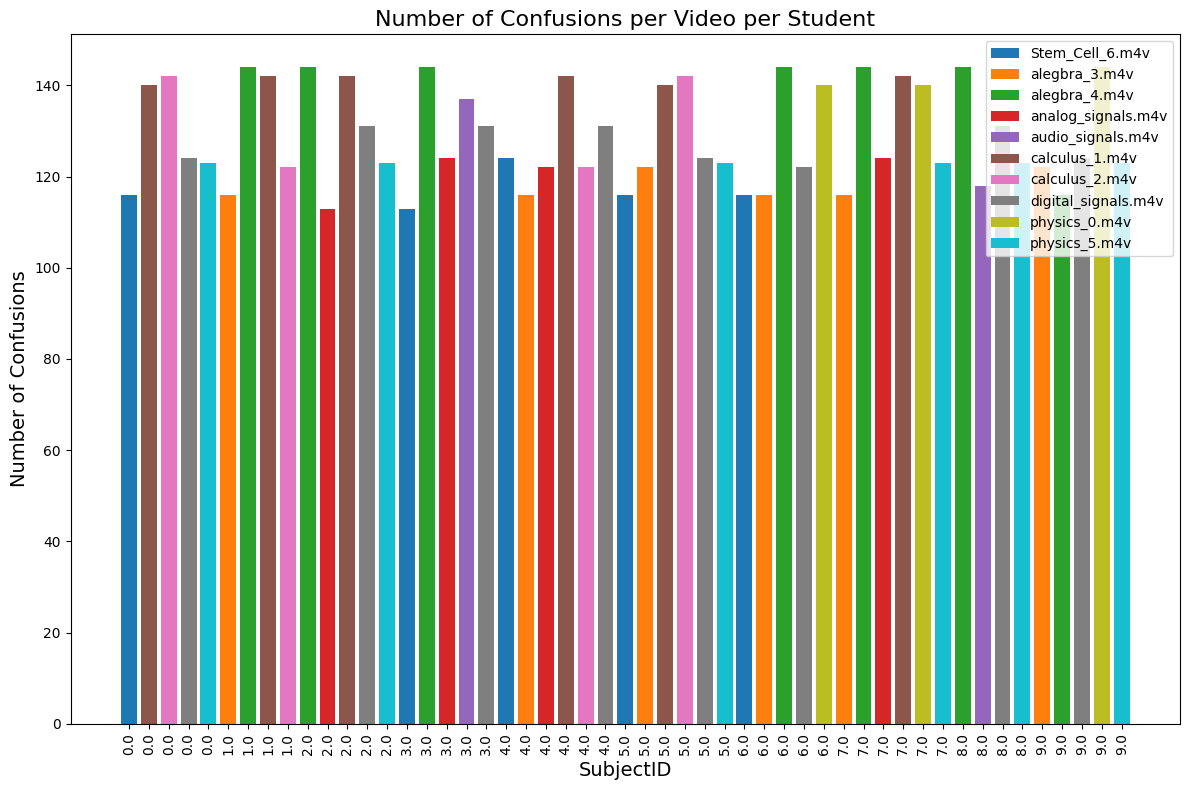

In [ ]:
# Group by both SubjectID and VideoID and count confused segments
confusion_counts_per_video_per_student = df[df['user-definedlabeln'] == 1].groupby(['SubjectID', 'VideoID']).size().reset_index(name='confused_count')
unique_video_ids = confusion_counts_per_video_per_student['VideoID'].unique()
num_colors = len(unique_video_ids)
color_map = plt.cm.get_cmap('tab10', num_colors)

# Plot
plt.figure(figsize=(12, 8))
for idx, (video_id, group) in enumerate(confusion_counts_per_video_per_student.groupby('VideoID')):
    plt.bar(group.index, group['confused_count'], color=color_map(idx), label=video_id)

plt.xlabel('SubjectID', fontsize=14)
plt.ylabel('Number of Confusions', fontsize=14)
plt.title('Number of Confusions per Video per Student', fontsize=16)
plt.xticks(confusion_counts_per_video_per_student.index, confusion_counts_per_video_per_student['SubjectID'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Aggregate the data by VideoID
confusion_counts = df.groupby('VideoID')['user-definedlabeln'].sum().reset_index()

# Rename the columns for clarity
confusion_counts.columns = ['VideoID', 'Number of Time Video Confused Students']

# Display the aggregated data
print(confusion_counts)

               VideoID  Number of Time Video Confused Students
0      Stem_Cell_6.m4v                                   585.0
1        alegbra_3.m4v                                   708.0
2        alegbra_4.m4v                                   980.0
3   analog_signals.m4v                                   483.0
4    audio_signals.m4v                                   255.0
5       calculus_1.m4v                                   848.0
6       calculus_2.m4v                                   528.0
7  digital_signals.m4v                                  1018.0
8        physics_0.m4v                                   424.0
9        physics_5.m4v                                   738.0


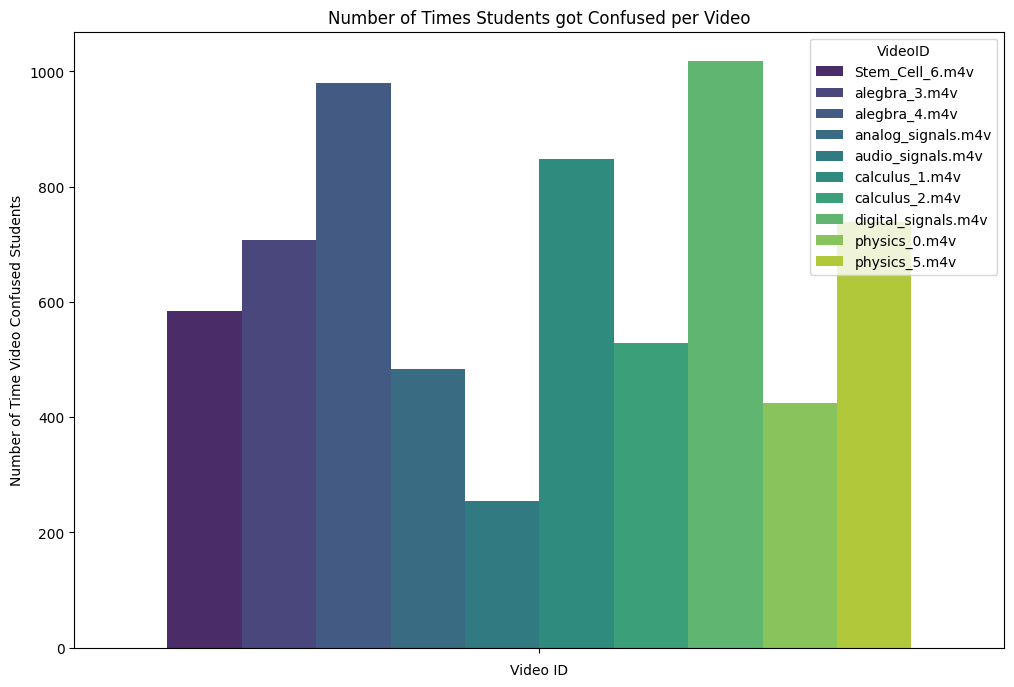

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(data=confusion_counts, hue='VideoID', y='Number of Time Video Confused Students', palette='viridis')

# Customize the plot
plt.title('Number of Times Students got Confused per Video')
plt.xlabel('Video ID')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Time Video Confused Students')

# Display the plot
plt.show()

# **3. Data Preprocessing and Feature Engineering**

We identify and count the missing values in each column to understand the extent of missing data. But in our dataset we dont have any missing values.

We handle missing values using SimpleImputer with the mean strategy, as the number of missing values is small. This prevents data loss that could occur if we simply dropped rows or columns with missing values.

In [ ]:
missing_values_count = df.isnull().sum()
columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()
if columns_with_missing_values :
    imputer = SimpleImputer(strategy='mean')
    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

    missing_values_count_after_imputation = df.isna().sum()
    columns_with_missing_values_after_imputation = missing_values_count_after_imputation[missing_values_count_after_imputation > 0].index.tolist()

    print("Columns with missing values after imputation:")
    print(columns_with_missing_values_after_imputation)
else:
  print("There is No missing value in dataset")


There is No missing value in dataset


In [ ]:
# label encoders
videoid_encoder = LabelEncoder()

df['VideoID'] = videoid_encoder.fit_transform(df['VideoID'])

videoid_mapping = dict(zip(videoid_encoder.classes_, videoid_encoder.transform(videoid_encoder.classes_)))

print("\nVideoID Mapping:")
print(videoid_mapping)


VideoID Mapping:
{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9)}


We encode categorical variables (ethnicity, gender, VideoID) into numerical values to make them suitable for machine learning algorithms.

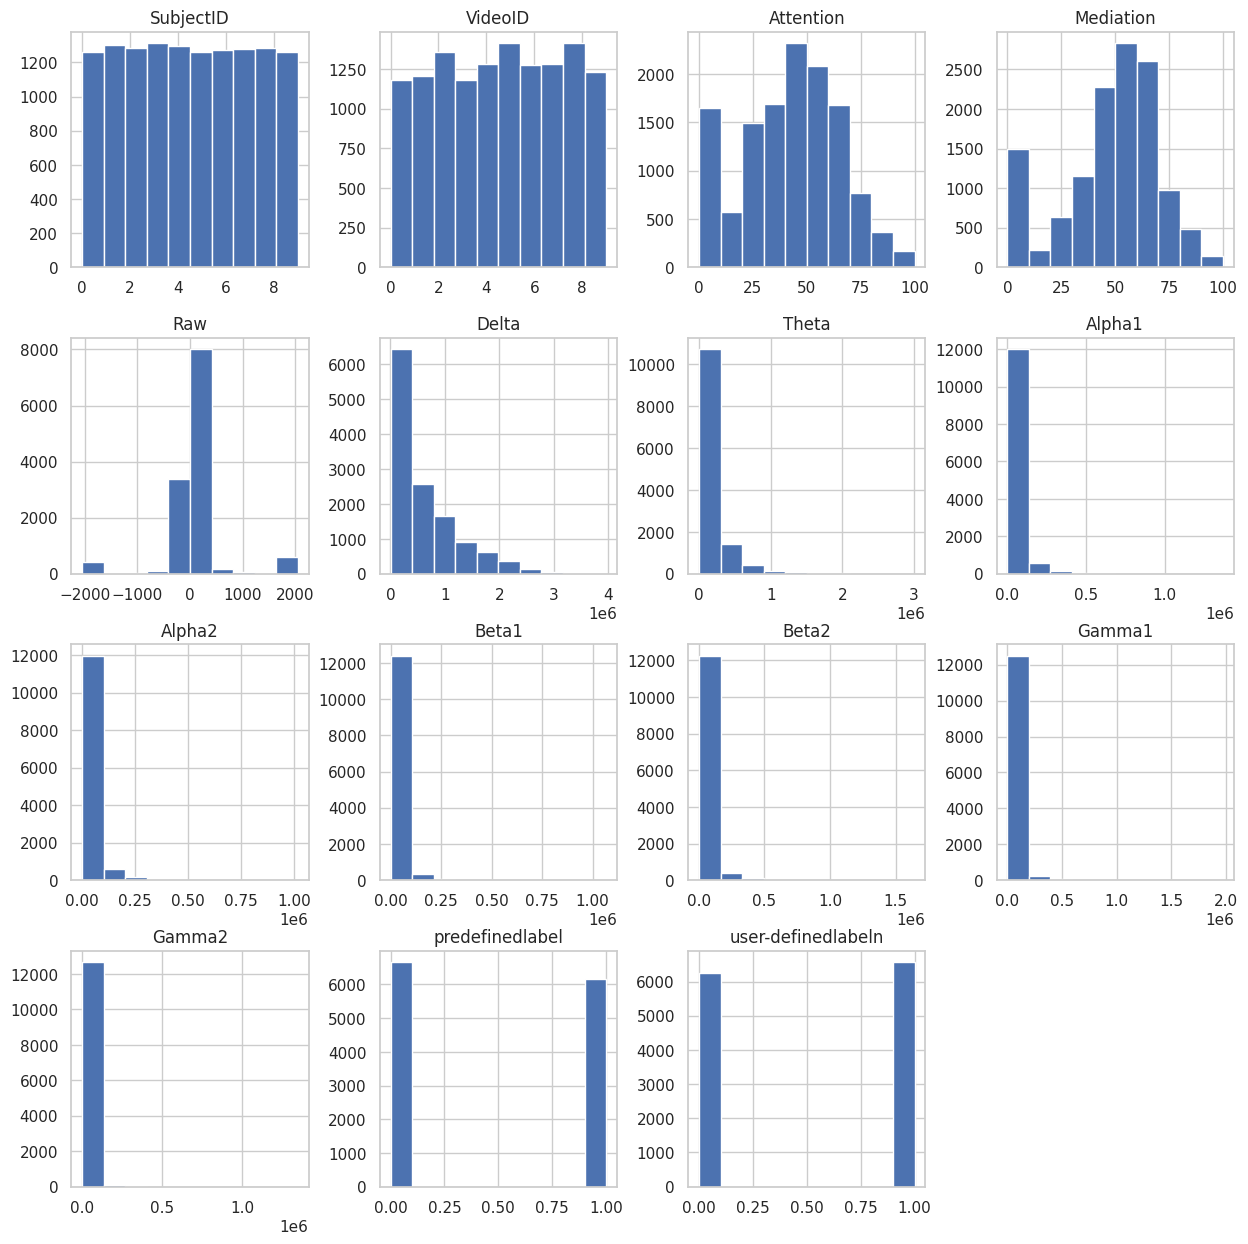

In [ ]:
df.hist(figsize = (15,15))
plt.show()

### Before Outliers

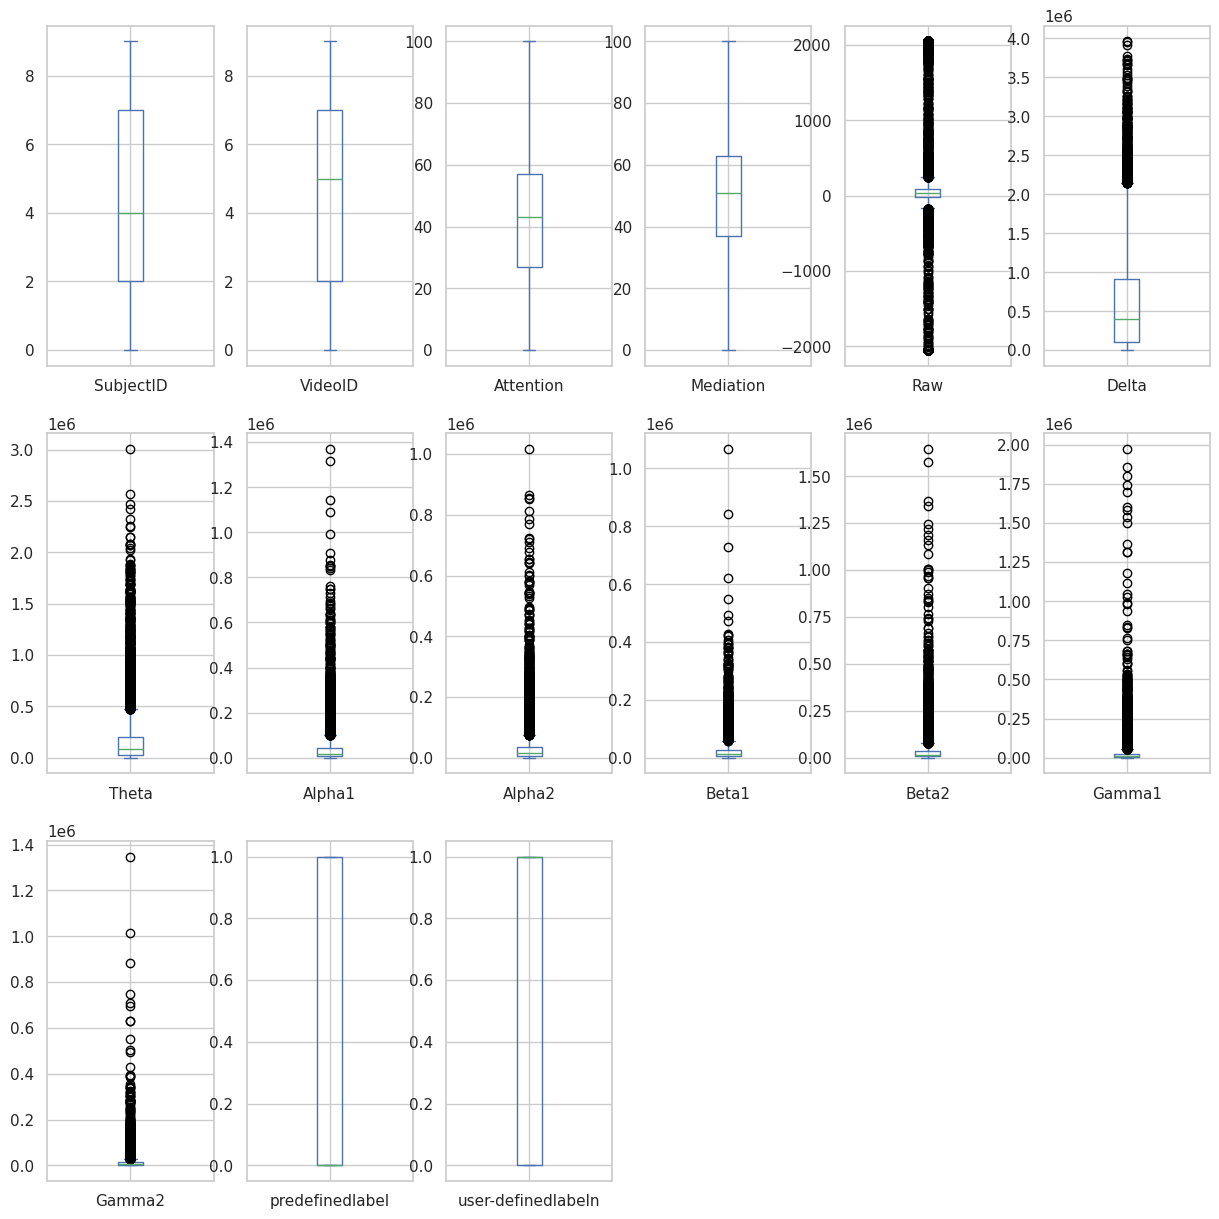

In [ ]:
# Box-plot

data = df.copy()
data.plot(kind='box',figsize=(15,15),subplots=True,layout=(3,6))
plt.show()

## Handling Outliers
### We cap the values of numerical features at the 1st and 99th percentiles to mitigate the effect of outliers.

In [ ]:
for feature in data:
    print(f"\nProcessing feature: {feature}")

    # Calculate the 1st and 99th percentiles for capping
    lower_percentile = data[feature].quantile(0.01)
    upper_percentile = data[feature].quantile(0.99)

    # Cap the outliers at the 1st and 99th percentiles
    data[feature] = np.where(data[feature] < lower_percentile, lower_percentile,
                             data[feature])
    data[feature] = np.where(data[feature] > upper_percentile, upper_percentile,
                             data[feature])

    print(f"Values for '{feature}' capped between {lower_percentile} and {upper_percentile}")



Processing feature: SubjectID
Values for 'SubjectID' capped between 0.0 and 9.0

Processing feature: VideoID
Values for 'VideoID' capped between 0.0 and 9.0

Processing feature: Attention
Values for 'Attention' capped between 0.0 and 91.0

Processing feature: Mediation
Values for 'Mediation' capped between 0.0 and 90.0

Processing feature: Raw
Values for 'Raw' capped between -2048.0 and 2047.0

Processing feature: Delta
Values for 'Delta' capped between 2733.3 and 2595771.8999999985

Processing feature: Theta
Values for 'Theta' capped between 3410.0 and 1253798.4999999958

Processing feature: Alpha1
Values for 'Alpha1' capped between 750.0 and 336929.29999999894

Processing feature: Alpha2
Values for 'Alpha2' capped between 981.3 and 277340.29999999976

Processing feature: Beta1
Values for 'Beta1' capped between 923.3 and 182545.19999999992

Processing feature: Beta2
Values for 'Beta2' capped between 1407.0 and 376426.29999999976

Processing feature: Gamma1
Values for 'Gamma1' capped 

### Outliers After Capped

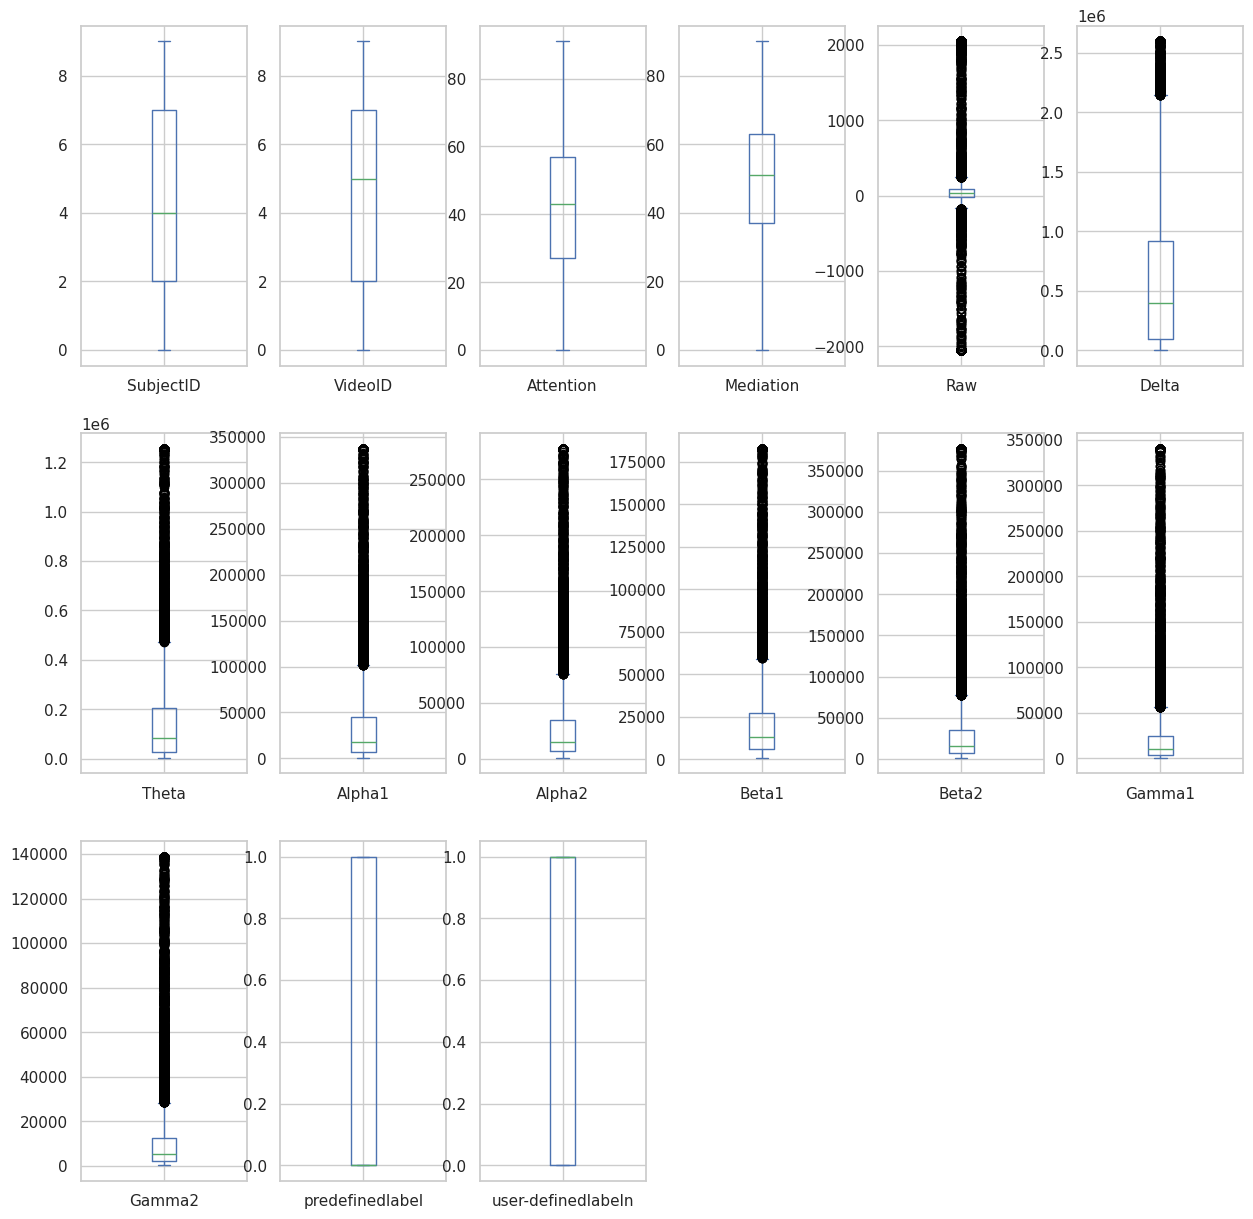

In [ ]:
# Box-plot

data.plot(kind='box',figsize=(15,15),subplots=True,layout=(3,6))
plt.show()

### Target Distribution

In [ ]:
data['user-definedlabeln'].value_counts()

,count
user-definedlabeln,
1.0,6567
0.0,6244


### Splitting the dataset based on user-defined labels

In [ ]:
X = data.drop(columns=['user-definedlabeln'])
y = data['user-definedlabeln']

print("Minimum value:", X.min())
print("Maximum value:", X.max())

Minimum value: SubjectID             0.0
VideoID               0.0
Attention             0.0
Mediation             0.0
Raw               -2048.0
Delta              2733.3
Theta              3410.0
Alpha1              750.0
Alpha2              981.3
Beta1               923.3
Beta2              1407.0
Gamma1              556.0
Gamma2              222.3
predefinedlabel       0.0
dtype: float64
Maximum value: SubjectID                9.0
VideoID                  9.0
Attention               91.0
Mediation               90.0
Raw                   2047.0
Delta              2595771.9
Theta              1253798.5
Alpha1              336929.3
Alpha2              277340.3
Beta1               182545.2
Beta2               376426.3
Gamma1              340048.0
Gamma2              138848.0
predefinedlabel          1.0
dtype: float64


## Correlation Matrix

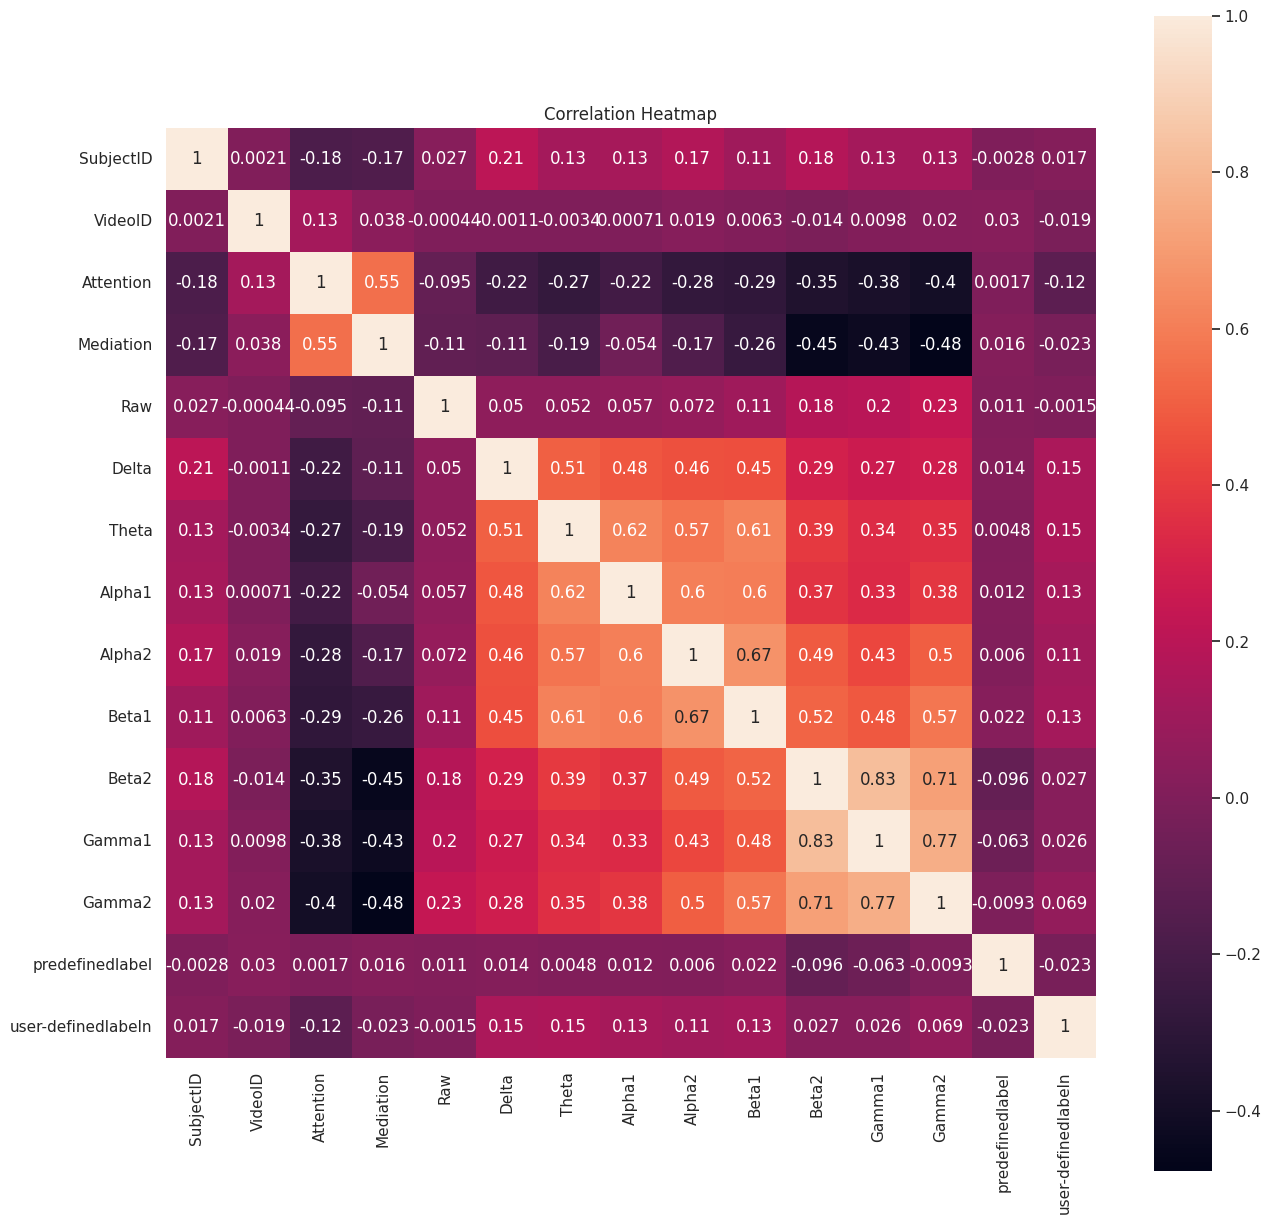

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

As from the heatmap, We see there is a good correlation between Gamma1 and Beta2

### Feature information

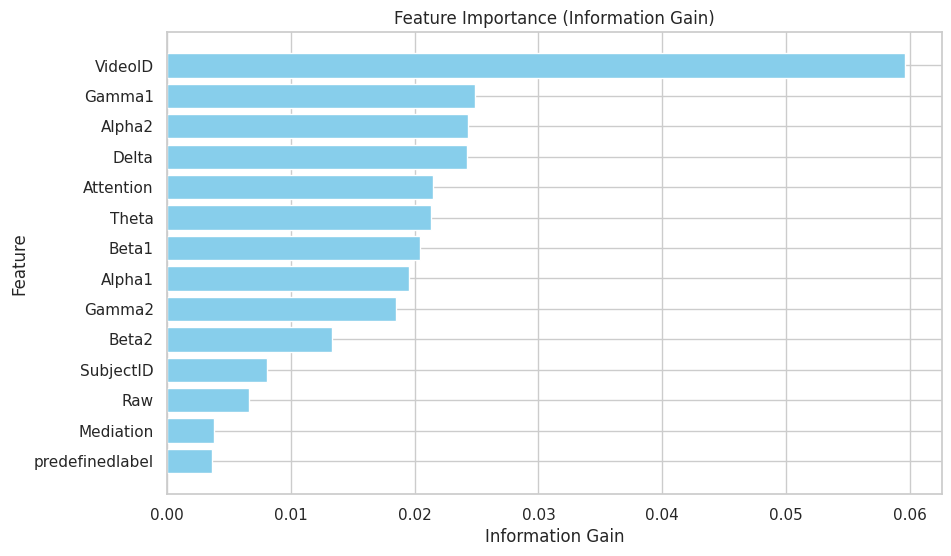

In [ ]:
information_gain = mutual_info_classif(X, y)

# Create a DataFrame to store feature names and their information gain
feature_information_gain = pd.DataFrame({'Feature': X.columns,'Information_Gain': information_gain})

# Sort features by information gain in descending order
feature_information_gain = feature_information_gain.sort_values(
    by='Information_Gain', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_information_gain['Feature'],
         feature_information_gain['Information_Gain'], color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.title('Feature Importance (Information Gain)')
plt.gca().invert_yaxis()  # y-axis to have the highest information gain on top
plt.show()

In [ ]:
# Create a DataFrame to store feature names and their information gain
feature_information_gain = pd.DataFrame({'Feature': X.columns, 'Information_Gain': information_gain})

# Sort features by information gain in descending order
feature_information_gain = feature_information_gain.sort_values(by='Information_Gain', ascending=False)

# Print the DataFrame
print("Feature Information Gain:")
print(feature_information_gain)

# Print the most important feature names
important_features = feature_information_gain['Feature'].tolist()
print("\nMost Important Features:")
print(important_features)

Feature Information Gain:
            Feature  Information_Gain
1           VideoID          0.059588
11           Gamma1          0.024909
8            Alpha2          0.024297
5             Delta          0.024269
2         Attention          0.021510
6             Theta          0.021336
9             Beta1          0.020471
7            Alpha1          0.019528
12           Gamma2          0.018516
10            Beta2          0.013308
0         SubjectID          0.008112
4               Raw          0.006661
3         Mediation          0.003801
13  predefinedlabel          0.003640

Most Important Features:
['VideoID', 'Gamma1', 'Alpha2', 'Delta', 'Attention', 'Theta', 'Beta1', 'Alpha1', 'Gamma2', 'Beta2', 'SubjectID', 'Raw', 'Mediation', 'predefinedlabel']


# **4. Model training (regular)**

In [ ]:
X_c = data.drop(columns=['user-definedlabeln','SubjectID','predefinedlabel','VideoID'])

X_c = StandardScaler().fit_transform(X_c)

X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2,random_state=200)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [ ]:
print("X Train Shape: ", X_train.shape)
print("Y Train Shape ",y_train.shape)
print("X Test Shape: ", X_test.shape)
print("Y Test Shape ",y_test.shape)

X Train Shape:  (10248, 11)
Y Train Shape  (10248,)
X Test Shape:  (2563, 11)
Y Test Shape  (2563,)


In [ ]:
n_estimators = [50, 100]
max_depth = [3, 5]
learning_rate = [0.01, 0.05, 0.1]
max_features = ['sqrt']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]

**XGBoost** is a powerful gradient boosting algorithm that excels in predictive performance and efficiency. It is known for its robustness to overfitting and ability to handle complex datasets.

**Random Forest** is an ensemble method that combines multiple decision trees to improve the model's accuracy and robustness. It is effective in handling high-dimensional data and can capture non-linear relationships.

**Gradient Boosting** builds models sequentially and each new model attempts to correct the errors made by the previous one. This method is effective in reducing bias and variance, leading to highly accurate models.


In [ ]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
models = [
    ('xgb', make_pipeline(StandardScaler(), xgb.XGBClassifier(objective='binary:logistic', seed=1)), {
        'xgbclassifier__n_estimators': n_estimators,
        'xgbclassifier__max_depth': max_depth,
        'xgbclassifier__learning_rate': learning_rate,
    }),
    ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42)), {
        'randomforestclassifier__n_estimators': n_estimators,
        'randomforestclassifier__max_depth': [5, 10],
        'randomforestclassifier__max_features': max_features,
        'randomforestclassifier__min_samples_split': min_samples_split,
        'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    }),
    ('gb', make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42)), {
        'gradientboostingclassifier__n_estimators': n_estimators,
        'gradientboostingclassifier__max_depth': max_depth,
        'gradientboostingclassifier__learning_rate': [0.01, 0.1],
        'gradientboostingclassifier__max_features': max_features,
        'gradientboostingclassifier__min_samples_split': min_samples_split,
        'gradientboostingclassifier__min_samples_leaf': min_samples_leaf,
    }),
]

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
f1_scores = []
accuracy_scores = []
model_names = []
conf_matrices = []
precision_scores = []
recall_scores = []

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"\n{model_name.upper()} Results:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    model_names.append(model_name)
    conf_matrices.append(conf_matrix)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")


XGB Results:
Best Parameters: {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}
Best Score: 0.6443215845921271
Precision: 0.6489
Recall: 0.6499
Accuracy: 0.6403
F1 Score: 0.6494

RF Results:
Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Best Score: 0.6542758513968742
Precision: 0.6426
Recall: 0.6499
Accuracy: 0.6352
F1 Score: 0.6462

GB Results:
Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 5, 'gradientboostingclassifier__n_estimators': 100}
Best Score: 0.6482251663512243
Precision: 0.6357
Recall: 0.6613
Accuracy: 0.63

## **4.1 Results**

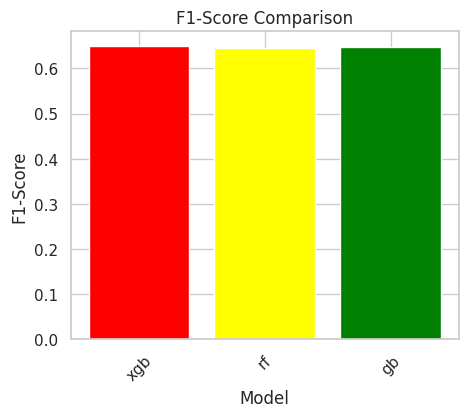

In [ ]:
colors = ['red', 'yellow', 'green']

# Bar plot for F1-scores
plt.figure(figsize=(5, 4))
plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks(rotation=45)
plt.show()

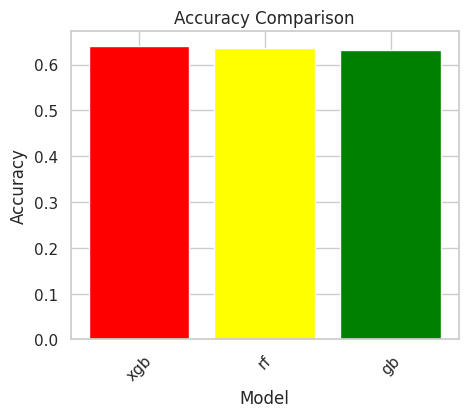

In [ ]:
colors = ['red', 'yellow', 'green']
plt.figure(figsize=(5, 4))
plt.bar(model_names, accuracy_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# **5. Model Training (Subject-Independent)**

In [ ]:
def split_data(X, y, train_subject, val_subject, test_subject):
    """
    Splits the data into training, validation, and test sets based on subject IDs.
    """
    # Split the data into training and testing sets
    X_train = X[X['SubjectID'].isin(train_subject)].drop(columns=['SubjectID', 'VideoID', 'predefinedlabel'])
    X_train = StandardScaler().fit_transform(X_train)
    y_train = y[X['SubjectID'].isin(train_subject)]

    if val_subject is not None:
        X_val = X[X['SubjectID'].isin(val_subject)].drop(columns=['SubjectID', 'VideoID', 'predefinedlabel'])
        X_val = StandardScaler().fit_transform(X_val)
        y_val = y[X['SubjectID'].isin(val_subject)]
    else:
        X_val = None
        y_val = None

    X_test = X[X['SubjectID'].isin(test_subject)].drop(columns=['SubjectID', 'VideoID','predefinedlabel'])
    X_test = StandardScaler().fit_transform(X_test)
    y_test = y[X['SubjectID'].isin(test_subject)]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
all_splits = []

for test_subject in range(10):
    train_subject = [i for i in range(10) if i not in [test_subject]]

    all_splits.append({
        'train_subject': train_subject,
        'test_subject': [test_subject]
    })

In [ ]:
for split in all_splits:
    print(split['train_subject'], split['test_subject'])

[1, 2, 3, 4, 5, 6, 7, 8, 9] [0]
[0, 2, 3, 4, 5, 6, 7, 8, 9] [1]
[0, 1, 3, 4, 5, 6, 7, 8, 9] [2]
[0, 1, 2, 4, 5, 6, 7, 8, 9] [3]
[0, 1, 2, 3, 5, 6, 7, 8, 9] [4]
[0, 1, 2, 3, 4, 6, 7, 8, 9] [5]
[0, 1, 2, 3, 4, 5, 7, 8, 9] [6]
[0, 1, 2, 3, 4, 5, 6, 8, 9] [7]
[0, 1, 2, 3, 4, 5, 6, 7, 9] [8]
[0, 1, 2, 3, 4, 5, 6, 7, 8] [9]


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

f1_scores = []
accuracy_scores = []
model_names = []
conf_matrices = []
precision_scores = []
recall_scores = []
test_subjects = []  # Track test subjects
best_params_list = []  # Track best parameters

results = []  # For DataFrame construction

for split in all_splits:
    train_subjects = split['train_subject']
    test_subject = split['test_subject']

    print(f"\n--- Processing Split with Test Subject {test_subject} ---")

    # Split the data (subject independent)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, train_subjects, None, test_subject)

    for model_name, model, param_grid in models:
        print(f"\nTraining {model_name} for test subject {test_subject}...")

        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"\n{model_name.upper()} Results:")
        print("Best Parameters:", grid_search.best_params_)
        print("Best Score:", grid_search.best_score_)

        best_model = grid_search.best_estimator_
        predictions = best_model.predict(X_test)

        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        conf_matrix = confusion_matrix(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)

        # Append to lists
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        model_names.append(model_name)
        conf_matrices.append(conf_matrix)
        precision_scores.append(precision)
        recall_scores.append(recall)
        test_subjects.append(test_subject)
        best_params_list.append(grid_search.best_params_)

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Store results for DataFrame
        results.append({
            'Test Subject': test_subject,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Best Parameters': str(grid_search.best_params_)  # Convert dict to string for DataFrame
        })


--- Processing Split with Test Subject [0] ---

Training xgb for test subject [0]...

XGB Results:
Best Parameters: {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 50}
Best Score: 0.5632034632034632
Precision: 0.5718
Recall: 0.6295
Accuracy: 0.5694
F1 Score: 0.5993

Training rf for test subject [0]...

RF Results:
Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Best Score: 0.565974025974026
Precision: 0.5520
Recall: 0.6915
Accuracy: 0.5551
F1 Score: 0.6139

Training gb for test subject [0]...

GB Results:
Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclas

In [ ]:
# Create and save results DataFrame
results_df = pd.DataFrame(results)
print("\nResults DataFrame:")
print(results_df)

# Save results to CSV
results_df.to_csv('model_evaluation_results.csv', index=False)
print("Results saved to model_evaluation_results.csv")

# Calculate average metrics by model
model_avg = results_df.groupby('Model')[['Precision', 'Recall', 'Accuracy', 'F1 Score']].mean()
print("\nAverage metrics by model:")
print(model_avg)


Results DataFrame:
   Test Subject Model  Precision    Recall  Accuracy  F1 Score  \
0           [0]   xgb   0.571831  0.629457  0.569389  0.599262   
1           [0]    rf   0.551980  0.691473  0.555115  0.613902   
2           [0]    gb   0.563739  0.617054  0.559873  0.589193   
3           [1]   xgb   0.484375  0.769084  0.577248  0.594395   
4           [1]    rf   0.464586  0.738550  0.551883  0.570376   
5           [1]    gb   0.454857  0.759542  0.536510  0.568978   
6           [2]   xgb   0.502994  0.771822  0.496106  0.609063   
7           [2]    rf   0.490659  0.764165  0.476636  0.597605   
8           [2]    gb   0.483837  0.710567  0.467290  0.575682   
9           [3]   xgb   0.610294  0.639445  0.620244  0.624530   
10          [3]    rf   0.591099  0.654854  0.605784  0.621345   
11          [3]    gb   0.573092  0.682589  0.592085  0.623066   
12          [4]   xgb   0.686441  0.642008  0.619305  0.663481   
13          [4]    rf   0.682203  0.638045  0.614672  0.

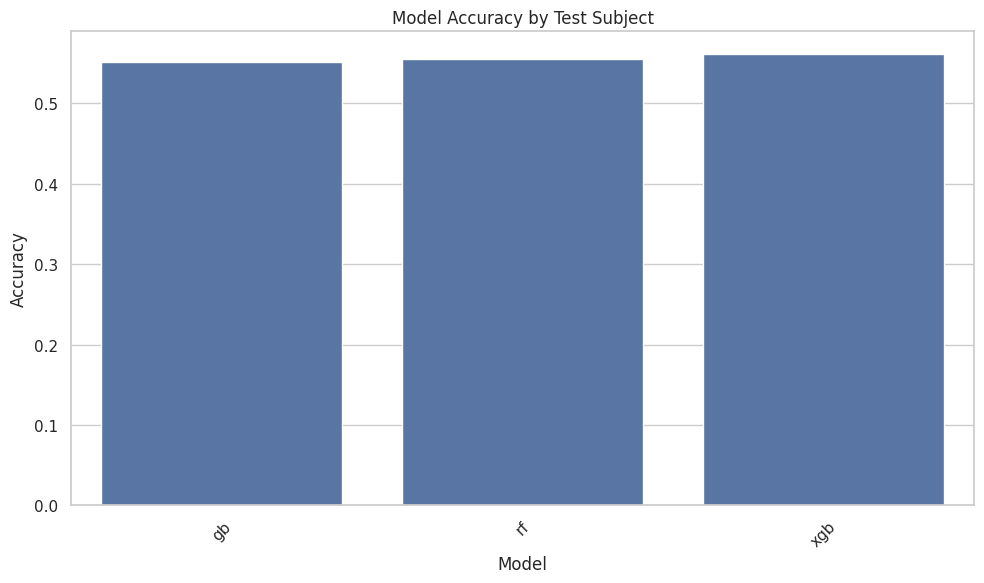

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot average accuracy by model
plt.figure(figsize=(10, 6))
sns.barplot(x=model_avg.index, y=model_avg['Accuracy'])
plt.title('Average Accuracy by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_accuracy.png')

# Plot accuracy by test subject
plt.title('Model Accuracy by Test Subject')
plt.tight_layout()
plt.savefig('subject_model_accuracy.png')


# **6. Subject Independent training using MLP and CNN models**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/numbstudent/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost/main/EEG_data.csv', encoding='utf-8')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [ ]:
num_subjects = df['SubjectID'].nunique()
print(f"Number of unique subjects: {num_subjects}")

# select feature columns and target column
feature_cols = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2", "Attention", "Mediation", "Raw"]
target_col = 'user-definedlabeln'

num_classes = df[target_col].nunique()
print(f"Number of unique classes in '{target_col}': {num_classes}")

Number of unique subjects: 10
Number of unique classes in 'user-definedlabeln': 2


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.features = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(df[target_col].astype('category').cat.codes.values, dtype=torch.long)
        self.num_samples = len(df)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x


In [ ]:
BATCH_SIZE = 64
MAX_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 2

all_results = []

# Iterate through the subject splits (leave-one-subject-out validation)
for test_subject in range(num_subjects):
    train_subjects = [i for i in range(num_subjects) if i not in [test_subject, (test_subject - 1 + num_subjects) % num_subjects]]
    val_subject = (test_subject - 1 + num_subjects) % num_subjects

    print(f"\n--- Test Subject: {test_subject}, Validation Subject: {val_subject}, Train Subjects: {train_subjects} ---")

    train_df = df[df['SubjectID'].isin(train_subjects)]
    val_df = df[df['SubjectID'] == val_subject]
    test_df = df[df['SubjectID'] == test_subject]

    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

    train_dataset = EEGDataset(train_df, feature_cols, target_col)
    val_dataset = EEGDataset(val_df, feature_cols, target_col)
    test_dataset = EEGDataset(test_df, feature_cols, target_col)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    input_size = len(feature_cols)
    model = CNN(input_size).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

    best_val_accuracy = -np.inf
    epochs_no_improve = 0
    best_model_state = None

    print("Starting training...")
    for epoch in range(MAX_EPOCHS):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        all_val_labels = []
        all_val_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{MAX_EPOCHS}], Train Loss: {total_train_loss / len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement on validation accuracy for {EARLY_STOPPING_PATIENCE} consecutive epochs.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model state found during validation for testing.")
    else:
        print("No best model state saved. Using last state.")

    print("Starting testing...")
    model.eval()
    all_test_labels = []
    all_test_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted.cpu().numpy())

    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
    test_recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

    print(f"Test Accuracy on Subject {test_subject}: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

    all_results.append({
        'test_subject': test_subject,
        'test_accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1
    })

print("\n--- Overall Results ---")
results_df = pd.DataFrame(all_results)
print(results_df)
print(f"\nAverage Test Accuracy across subjects: {results_df['test_accuracy'].mean():.4f}")
print(f"Average Precision: {results_df['precision'].mean():.4f}")
print(f"Average Recall: {results_df['recall'].mean():.4f}")
print(f"Average F1 Score: {results_df['f1_score'].mean():.4f}")



--- Test Subject: 0, Validation Subject: 9, Train Subjects: [1, 2, 3, 4, 5, 6, 7, 8] ---
Train size: 10289, Validation size: 1261, Test size: 1261
Starting training...
Epoch [1/30], Train Loss: 0.6755, Val Accuracy: 0.5321, LR: 0.000997
Epoch [2/30], Train Loss: 0.6704, Val Accuracy: 0.5400, LR: 0.000989
Epoch [3/30], Train Loss: 0.6689, Val Accuracy: 0.5218, LR: 0.000976
Epoch [4/30], Train Loss: 0.6687, Val Accuracy: 0.5361, LR: 0.000957
Epoch [5/30], Train Loss: 0.6662, Val Accuracy: 0.5274, LR: 0.000933
Epoch [6/30], Train Loss: 0.6663, Val Accuracy: 0.5337, LR: 0.000905
Epoch [7/30], Train Loss: 0.6656, Val Accuracy: 0.5400, LR: 0.000872
Epoch [8/30], Train Loss: 0.6640, Val Accuracy: 0.5400, LR: 0.000835
Epoch [9/30], Train Loss: 0.6632, Val Accuracy: 0.5297, LR: 0.000794
Epoch [10/30], Train Loss: 0.6619, Val Accuracy: 0.5369, LR: 0.000750
Epoch [11/30], Train Loss: 0.6615, Val Accuracy: 0.5400, LR: 0.000703
Epoch [12/30], Train Loss: 0.6601, Val Accuracy: 0.5321, LR: 0.000655


# **7. Subject Independent with Different Data Preprocessing**

After numerous attempts to improve accuracy of our classification model, we decided to aggregate data so that it will have a more compressed and rich data to train a classifier. Also, we tested more simpler models such as LDA, LogReg and SVM along with XGBoost. We were able to achieve highest accuracy score of 0.71.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/numbstudent/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost/main/EEG_data.csv')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

exclude_cols = ['SubjectID', 'VideoID', 'predefinedlabel', 'user-definedlabeln']
eeg_cols = [col for col in df.columns if col not in exclude_cols]
grouped = df.groupby(['SubjectID', 'VideoID'])

agg_funcs = ['mean', 'std', 'min', 'max', 'skew', 'median']
aggregated_df = grouped[eeg_cols].agg(agg_funcs)
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]

aggregated_df.reset_index(inplace=True)
aggregated_df['predefinedlabel'] = grouped['predefinedlabel'].first().values
aggregated_df['user_definedlabeln'] = grouped['user-definedlabeln'].first().values

print(aggregated_df.shape)
print(aggregated_df.head())


(100, 70)
   SubjectID  VideoID  Attention_mean  Attention_std  Attention_min  \
0        0.0      0.0       55.256944      22.838058           13.0   
1        0.0      1.0       43.621429      14.953870            7.0   
2        0.0      2.0       43.978873      14.095152            3.0   
3        0.0      3.0       51.057377      21.949717            1.0   
4        0.0      4.0       55.224138      21.865234            1.0   

   Attention_max  Attention_skew  Attention_median  Mediation_mean  \
0          100.0       -0.064008              57.0       53.826389   
1           77.0       -0.439566              47.0       48.621429   
2           88.0       -0.186042              43.5       47.316901   
3          100.0       -0.109321              52.0       51.844262   
4          100.0       -0.067482              53.0       47.474138   

   Mediation_std  ...  Gamma1_skew  Gamma1_median   Gamma2_mean    Gamma2_std  \
0      13.480538  ...     2.292793        29328.5  16817.0625

In [ ]:
X =  aggregated_df.drop(columns=['user_definedlabeln'])
y = aggregated_df['user_definedlabeln']

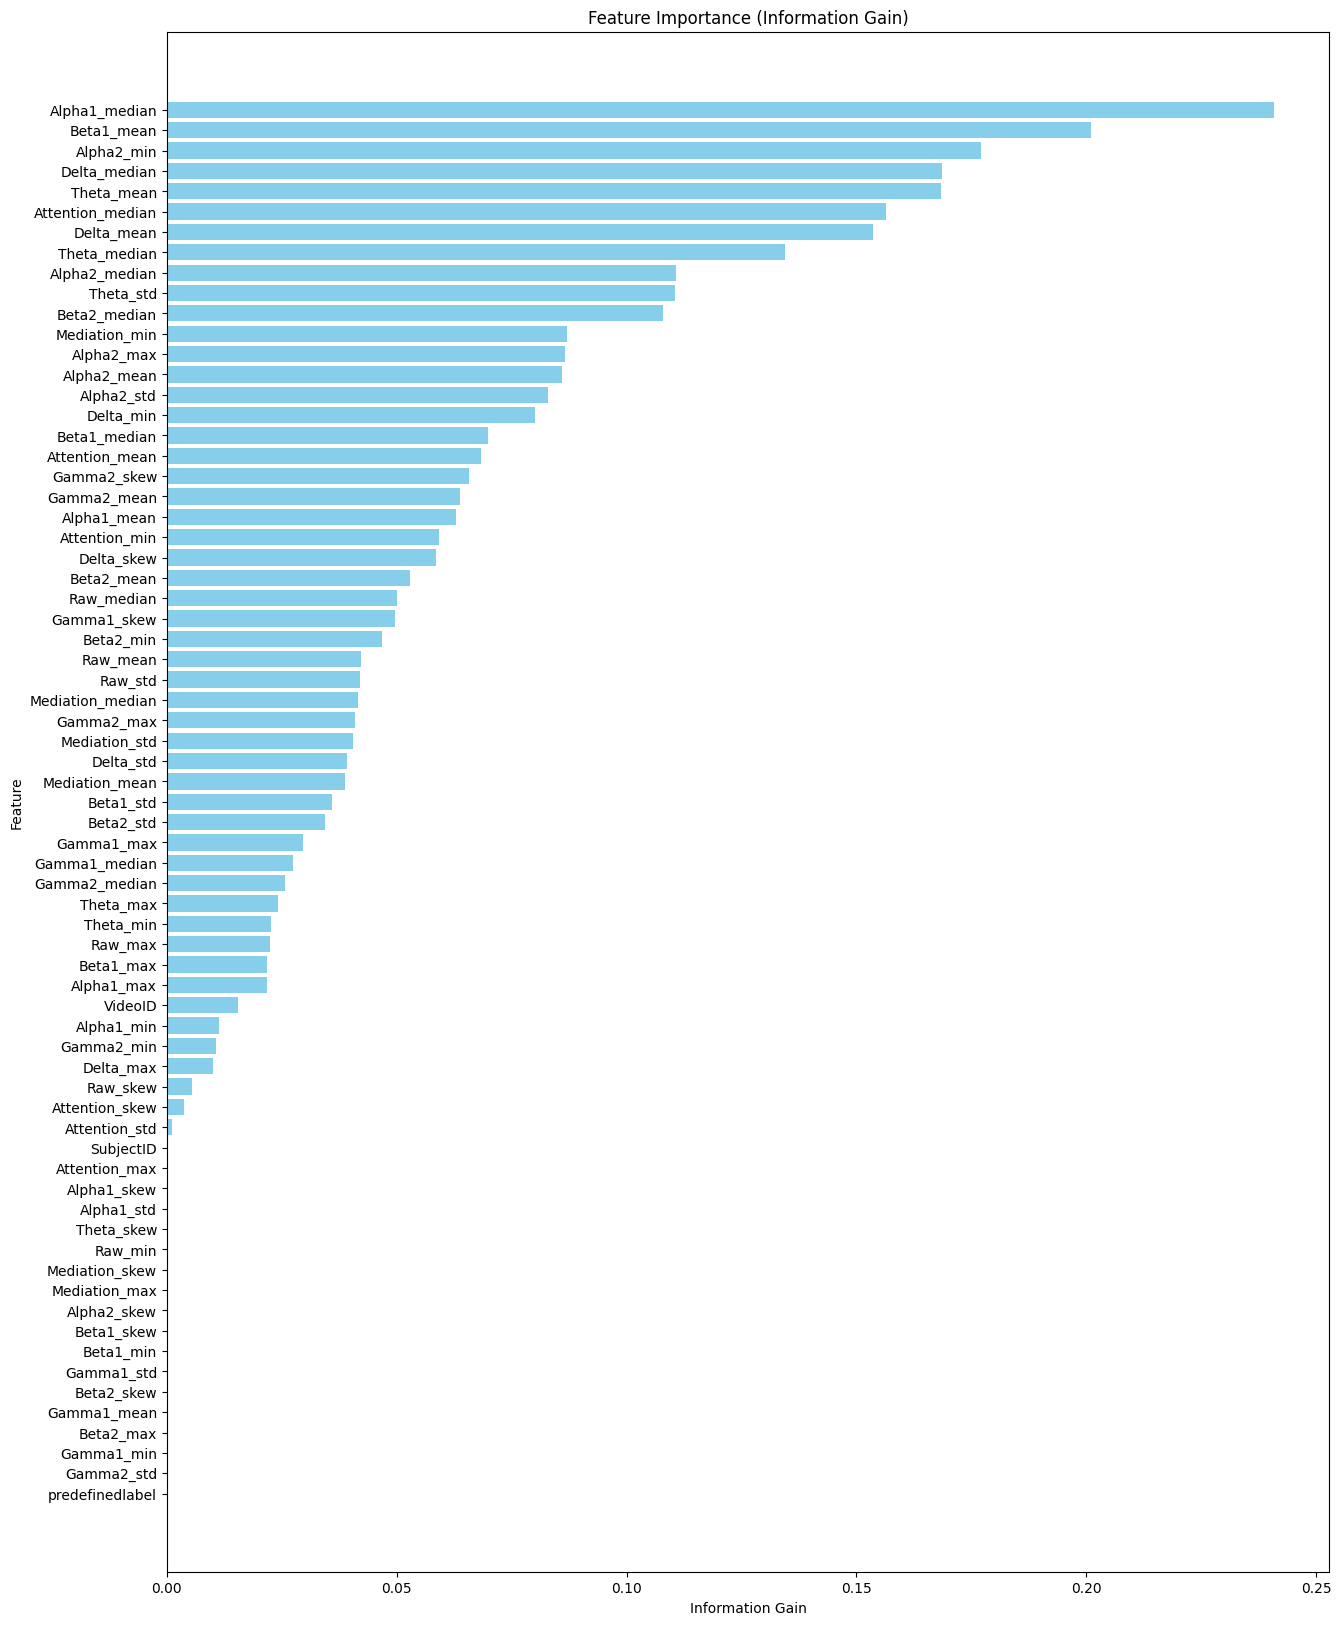

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
information_gain = mutual_info_classif(X, y)

feature_information_gain = pd.DataFrame({'Feature': X.columns,'Information_Gain': information_gain})
# Sort features by information gain in descending order
feature_information_gain = feature_information_gain.sort_values(
    by='Information_Gain', ascending=False)
plt.figure(figsize=(15, 20))
plt.barh(feature_information_gain['Feature'],
         feature_information_gain['Information_Gain'], color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.title('Feature Importance (Information Gain)')
plt.gca().invert_yaxis()  # y-axis to have the highest information gain on top
plt.show()

In [ ]:
# Set global seed
RANDOM_SEED = 22
np.random.seed(RANDOM_SEED)

# Prepare data
X_full = aggregated_df.drop(columns=['SubjectID', 'VideoID', 'predefinedlabel', 'user_definedlabeln'])
y = aggregated_df['user_definedlabeln']
groups = aggregated_df['SubjectID']
K = 28

# Define classifiers with random_state
models = {
    'LDA': LDA(solver='lsqr', shrinkage='auto'),
    'LogReg_L1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=4000, random_state=RANDOM_SEED),
    'LogReg_L2': LogisticRegression(penalty='l2', solver='liblinear', max_iter=4000, random_state=RANDOM_SEED),
    'SVM_Linear': SVC(kernel='linear', probability=True, max_iter=5000, random_state=RANDOM_SEED),
    'SVM_RBF': SVC(kernel='rbf', probability=True, max_iter=5000, random_state=RANDOM_SEED),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=RANDOM_SEED)
}

# Evaluation function
def evaluate_model(model, X_full, y, groups, k):
    logo = LeaveOneGroupOut()
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for train_idx, test_idx in logo.split(X_full, y, groups=groups):
        X_train_full, X_test_full = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Feature selection
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train_full, y_train)
        X_test_selected = selector.transform(X_test_full)

        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_selected)
        X_test = scaler.transform(X_test_selected)

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Store metrics
        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        scores['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        scores['f1'].append(f1_score(y_test, y_pred, zero_division=0))

    return {metric: np.mean(vals) for metric, vals in scores.items()}

# Run and collect results
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = evaluate_model(model, X_full, y, groups, K)
    results[name] = scores

# Display results
results_df = pd.DataFrame(results).T
print("\nLOSOCV Results (Top 28 Features + Scaling + Seed):")
print(results_df.round(4))


Evaluating LDA...
Evaluating LogReg_L1...
Evaluating LogReg_L2...
Evaluating SVM_Linear...
Evaluating SVM_RBF...
Evaluating XGBoost...

LOSOCV Results (Top 28 Features + Scaling + Seed):
            accuracy  precision  recall      f1
LDA             0.67     0.6167  0.6433  0.5838
LogReg_L1       0.62     0.5333  0.6817  0.5771
LogReg_L2       0.64     0.5342  0.6850  0.5844
SVM_Linear      0.63     0.5405  0.6617  0.5771
SVM_RBF         0.64     0.5871  0.6350  0.5657
XGBoost         0.73     0.7292  0.8217  0.7492


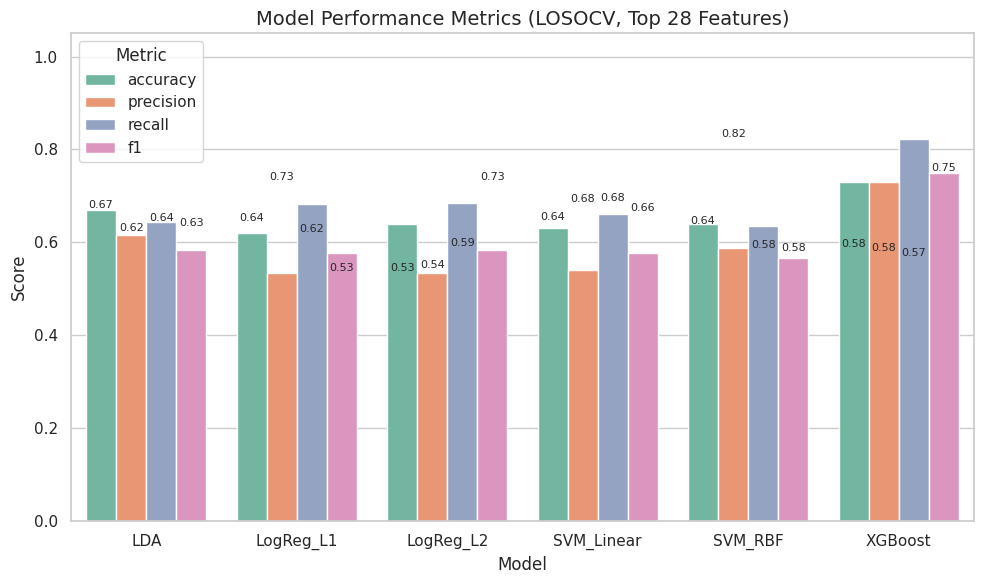

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
results_df_plot = results_df.copy()
results_df_plot.index.name = 'Model'
results_df_plot.reset_index(inplace=True)

# Melt the DataFrame to long format for seaborn
results_melted = results_df_plot.melt(id_vars='Model', value_vars=['accuracy', 'precision', 'recall', 'f1'],
                                      var_name='Metric', value_name='Score')

# Set plot style
sns.set(style="whitegrid")

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='Set2')

# Annotate scores on bars
for i in range(results_melted.shape[0]):
    row = results_melted.iloc[i]
    plt.text(i // 4 + (i % 4) * 0.2 - 0.3, row['Score'] + 0.005, f"{row['Score']:.2f}", ha='center', fontsize=8)

plt.title('Model Performance Metrics (LOSOCV, Top 28 Features)', fontsize=14)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [ ]:
aggregated_df

,SubjectID,VideoID,Attention_mean,Attention_std,Attention_min,Attention_max,Attention_skew,Attention_median,Mediation_mean,Mediation_std,...,Gamma1_skew,Gamma1_median,Gamma2_mean,Gamma2_std,Gamma2_min,Gamma2_max,Gamma2_skew,Gamma2_median,predefinedlabel,user_definedlabeln
0,0.0,0.0,55.256944,22.838058,13.0,100.0,-0.064008,57.0,53.826389,13.480538,...,2.292793,29328.5,16817.062500,13992.645154,1175.0,84108.0,1.865324,13104.5,0.0,0.0
1,0.0,1.0,43.621429,14.953870,7.0,77.0,-0.439566,47.0,48.621429,12.456236,...,1.056426,29606.5,14519.407143,12589.073301,81.0,84001.0,1.891500,10958.5,0.0,1.0
2,0.0,2.0,43.978873,14.095152,3.0,88.0,-0.186042,43.5,47.316901,13.732175,...,1.635801,27109.0,14545.845070,12391.644533,524.0,66255.0,1.545940,10977.5,0.0,1.0
3,0.0,3.0,51.057377,21.949717,1.0,100.0,-0.109321,52.0,51.844262,12.607239,...,2.161688,31548.0,16558.631148,16304.126506,1018.0,112579.0,2.672062,11812.5,0.0,0.0
4,0.0,4.0,55.224138,21.865234,1.0,100.0,-0.067482,53.0,47.474138,12.186565,...,1.731046,28606.0,14752.655172,10755.786413,947.0,49188.0,1.034120,11745.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.0,5.0,49.813008,20.175602,0.0,100.0,0.079887,51.0,41.048780,24.734940,...,2.363070,32448.0,22656.227642,23485.282390,937.0,138218.0,2.178768,15022.0,1.0,1.0
96,9.0,6.0,29.620690,12.581322,1.0,56.0,-0.058486,27.0,53.293103,13.461712,...,3.862832,8854.0,3854.594828,4627.463411,117.0,26351.0,2.828625,2260.0,1.0,0.0
97,9.0,7.0,27.633929,11.180739,4.0,57.0,0.409988,26.0,48.366071,16.646291,...,7.484668,8817.5,2697.937500,5542.286492,163.0,54829.0,7.809308,1402.5,1.0,0.0
98,9.0,8.0,55.548387,19.858587,10.0,100.0,-0.094224,56.0,52.879032,14.145925,...,1.457872,32191.5,17554.927419,16472.015893,685.0,106159.0,2.107730,11894.5,1.0,1.0
